# Método Q-Learning para _cliff walking_

[**Juan Gómez Romero**](https://decsai.ugr.es/~jgomez)  
Departamento de Ciencias de la Computación e Inteligencia Artificial  
Universidad de Granada  
This work is licensed under the [GNU General Public License v3.0](https://choosealicense.com/licenses/gpl-3.0/).

---
Ejemplo basado en:
> R.S. Sutton, A.G. Barto (2018) Reinforcement Learning. Chapters 6.5: Q-learning: Off-policy TD Control, 6.6: Expected Sarsa.

_Consider the gridworld shown to the right. This is a standard undiscounted, episodic task, with start and goal states, and the usual actions causing movement up, down, right, and left. Reward is -1 on all transitions except those into the region marked "The Cliff" Stepping into this region incurs a reward of -100 and sends the agent instantly back to the start._

![](cliffwalking.png)

> Udacity (2019) Deep Reinforcement Learning Course. Disponible en [GitHub](https://github.com/udacity/deep-reinforcement-learning/blob/master/temporal-difference/Temporal_Difference_Solution.ipynb).

## Algoritmo
A continuación se proporciona una implementación genérica del algoritmo Q-Learning.

In [1]:
import sys
import gym
import numpy as np
import matplotlib.pyplot as plt

from collections import defaultdict, deque

def generate_action_from_Q_epsilon(discrete_env, Q, epsilon, state):
    """Generador de acciones:
    Params
    ======
    env: entorno con espacio de acciones discreto
    Q: tabla Q, definida como un diccionario Q[state][action] = reward
    state: estado actual
    bins: intervalos de discretizacion para valores de estado
    epsilon: valor para epsilon-greedy"""
       
    r = np.random.uniform(size=1)[0]
    if r <= epsilon:
        action = env.action_space.sample()
    else:
        action = np.argmax(Q[state])
        
    return action

def qlearning(env, num_episodes, generate_action, step_limit=1000, gamma=1.0, alpha=0.01, epsilon=0.2, plot_every=100):
    """Algoritmo Q-Learning:
    Params
    ======
    env: entorno con espacio de acciones discreto
    num_episodes: numero de episodios a generar
    generate_accion: funcion para obtener siguiente accion
    gamma: tasa de descuento
    epsilon: valor para epsilon-greedy
    alpha: valor para alfa
    render: visualizar entorno"""

    # inicializar diccionarios
    Q = defaultdict(lambda: np.zeros(env.action_space.n))  # Q
    
    # bucle de episodios
    tmp_scores = deque(maxlen=plot_every)               # puntuacion de los ultimos 'plot_every' episodios
    avg_scores = deque(maxlen=num_episodes//plot_every) # puntuaciones medias los ultimos 'plot_every' episodios
    
    for i_episode in range(1, num_episodes+1):
        
        # monitorizar progreso
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()     

        # generar episodio
        state   = env.reset()
        done = False
        episode_score = 0        
        n_step = 0        

        # modificar epsilon 
        
        while True :
            # elegir accion segun politica epsilon-greedy
            action = generate_action(env, Q, epsilon, state)        
            
            # aplicar accion
            next_state, reward, done, _ = env.step(action)                          
            episode_score += reward
                        
            # actualizar Q           
            Q[state][action] = Q[state][action] + alpha * (reward + gamma * np.max(Q[next_state]) - Q[state][action])

            # comprobar fin de episodio
            n_step += 1
            if done or n_step > step_limit:                
                tmp_scores.append(episode_score)
                break
            
            # pasar al siguiente estado
            state = next_state
            
        if(i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
            
    # visualizar puntuaciones
    plt.plot(np.linspace(0, num_episodes, len(avg_scores), endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Numero de episodio')
    plt.ylabel('Puntuacion media de los siguientes %d episodios' % plot_every)
    plt.show()
    print(('Mejor puntuacion media obtenida: '), np.max(avg_scores))

    # construir politica
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
            
    return Q, policy

Para llamar al algoritmo, creamos el entorno y llamamos a la función `qlearning`. 

Episode 15000/15000.

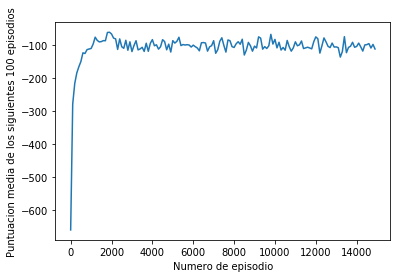

Mejor puntuacion media obtenida:  -62.63


In [2]:
env = gym.make('CliffWalking-v0')

Q, policy = qlearning(env, 15000, generate_action_from_Q_epsilon)

In [3]:
# Mostrar política como matriz
policy_plot = np.array([policy[key] if key in policy else -1 for key in np.arange(48)]).reshape(4, 12)
print("\nPolitica optima estimada(ARRIBA = 0, DERECHA = 1, ABAJO = 2, IZQUIERDA = 3, N/A = -1):")
print(policy_plot)


Politica optima estimada(ARRIBA = 0, DERECHA = 1, ABAJO = 2, IZQUIERDA = 3, N/A = -1):
[[ 1  1  2  1  1  1  1  1  1  1  1  2]
 [ 1  2  1  2  1  1  2  2  1  2  1  2]
 [ 1  1  1  1  1  1  1  1  1  1  1  2]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0]]


Visualicemos la funcion de estado-valor $v_\pi$ y comparemos con los valores óptimos $v_{\pi_*}$. 

Para visualizar los resultados es necesario disponer del fichero [_plot_\__utils.py_](https://github.com/jgromero/eci2019-DRL/blob/master/Tema%203%20-%20Aprendizaje%20por%20Refuerzo/code/plot_utils.py).

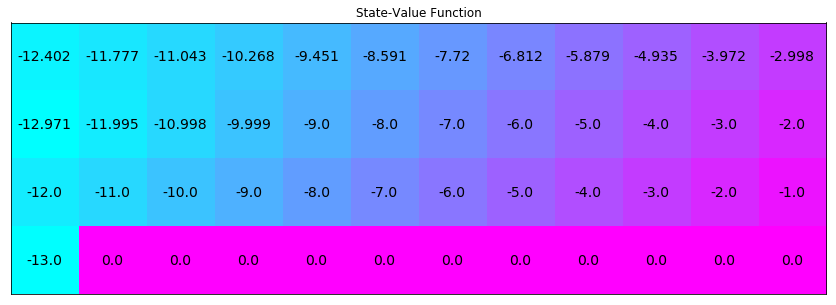

In [4]:
from plot_utils import plot_values
V = ([np.max(Q[key]) if key in Q else 0 for key in np.arange(48)])
plot_values(V)

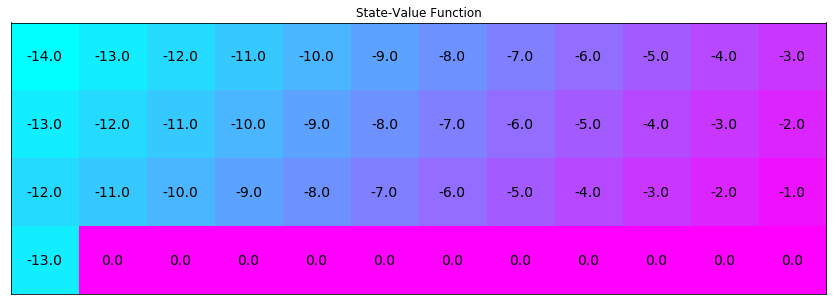

In [5]:
# Definir funcion optima
V_opt = np.zeros((4,12))
V_opt[0][0:13] = -np.arange(3, 15)[::-1]
V_opt[1][0:13] = -np.arange(3, 15)[::-1] + 1
V_opt[2][0:13] = -np.arange(3, 15)[::-1] + 2
V_opt[3][0] = -13
plot_values(V_opt)

---
### EJERCICIO

Modificar el valor de $\epsilon$ para que sea variable. Por ejemplo: $\epsilon = 1 / i\_episode$.


---